In [1]:
# Copyright 2017 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Example script to train the DNC on a repeated copy task."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import datetime
import tensorflow as tf

from dnc import dnc, access
from dnc import repeat_copy

from collections import namedtuple

flags_dict = {
    # Model parameters
    "hidden_size": 64, # Size of LSTM hidden layer.
    "memory_size": 16, # The number of memory slots.
    "word_size": 16, #"The width of each memory slot."
    "num_write_heads": 1, #"Number of memory write heads."
    "num_read_heads": 4, #"Number of memory read heads."
    "clip_value": 20,#"Maximum absolute value of controller and dnc outputs."

    # Optimizer parameters.
    "max_grad_norm": 50, #"Gradient clipping norm limit."
    "learning_rate": 1e-4, #"Optimizer learning rate."
    "optimizer_epsilon": 1e-10, #"Epsilon used for RMSProp optimizer."

    # Task parameters
    "batch_size": 16, #"Batch size for training."
    "num_bits": 4, #"Dimensionality of each vector to copy"
    "min_length": 1,#"Lower limit on number of vectors in the observation pattern to copy"
    "max_length": 2,#"Upper limit on number of vectors in the observation pattern to copy"
    "min_repeats": 1,#"Lower limit on number of copy repeats."
    "max_repeats": 2, #"Upper limit on number of copy repeats."

    "checkpoint_dir": "./checkpoints/repeat_copy", #"Checkpointing directory."
}

flags_schema = namedtuple('flags_schema', list(flags_dict.keys()))
FLAGS = flags_schema(**flags_dict)


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [7]:
def load_model():
    """Trains the DNC and periodically reports the loss."""
    access_config = {
        "memory_size": FLAGS.memory_size,
        "word_size": FLAGS.word_size,
        "num_reads": FLAGS.num_read_heads,
        "num_writes": FLAGS.num_write_heads,
    }
    controller_config = {
        #"hidden_size": FLAGS.hidden_size,
        "units": FLAGS.hidden_size,
    }
    clip_value = FLAGS.clip_value

    dnc_cell = dnc.DNC(
        access_config, controller_config, FLAGS.num_bits + 1, FLAGS.batch_size, clip_value)
    dnc_core = tf.keras.layers.RNN(
        cell=dnc_cell,
        time_major=True,
        return_sequences=True,
        return_state=True,
    )
    optimizer = tf.compat.v1.train.RMSPropOptimizer(
        FLAGS.learning_rate, epsilon=FLAGS.optimizer_epsilon)

    # Set up model checkpointing
    checkpoint = tf.train.Checkpoint(model=dnc_core, optimizer=optimizer)
    manager = tf.train.CheckpointManager(checkpoint, FLAGS.checkpoint_dir, max_to_keep=10)

    checkpoint.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")
    return dnc_core


dnc_core = load_model()

Restored from ./checkpoints/repeat_copy/ckpt-97


In [8]:
def read_weights_from_dnc_state(dnc_state):
    return dnc_state[dnc.ACCESS_STATE][access.READ_WEIGHTS]
def write_weights_from_dnc_state(dnc_state):
    return dnc_state[dnc.ACCESS_STATE][access.WRITE_WEIGHTS]
def memory_from_dnc_state(dnc_state):
    return dnc_state[dnc.ACCESS_STATE][access.MEMORY]


In [9]:
def evaluate_model(
    x,
    mask,
    rnn_model,
):
    output_sequence = []
    output_states = []
    input_state = rnn_model.get_initial_state(inputs=x)
    for input_seq in x:
        #print(tf.expand_dims(input_seq, axis=0))
        #print(input_state)
        output = rnn_model(
            inputs=tf.expand_dims(input_seq, axis=0),
            initial_state=input_state,
        )
        output_sequence.append(tf.round(tf.sigmoid(output[0])))
        input_state = output[1:]
        output_states.append(input_state)
    return output_sequence, output_states

get_outputs = lambda x: evaluate_model(x, None, dnc_core)


In [121]:
import seaborn
import matplotlib.pyplot as plt
import numpy as np

def visualize_results(obs, targ, pred, mask):
    obs = tf.transpose(obs)
    targ = tf.transpose(targ)
    pred = tf.transpose(tf.squeeze(pred))
    
    seaborn.set(rc = {'figure.figsize':(
        15.0 / 64 * obs.shape[1], # time, x-axis
        15.0 / 64 * obs.shape[0], # biz position, y-axis
    )})
    
    seaborn.heatmap(obs)
    plt.title('RepeatCopy Task Inputs')
    plt.xlabel('time step')
    plt.ylabel('bit position')
    plt.show()
    
    seaborn.heatmap(targ)
    plt.title('RepeatCopy Task Target')
    plt.xlabel('time step')
    plt.ylabel('bit position')
    plt.show()
    
    seaborn.heatmap(pred)
    plt.title('RepeatCopy Task Model Outputs')
    plt.xlabel('time step')
    plt.ylabel('bit position')
    plt.show()

def visualize_states(states):
    #memory = [memory_from_dnc_state(state)[0] for state in states]
    read_weights = [read_weights_from_dnc_state(state)[0] for state in states]
    read_weights = tf.transpose(tf.stack(read_weights), [1,2,0])
    
    write_weights = [write_weights_from_dnc_state(state)[0] for state in states]
    write_weights = tf.transpose(tf.stack(write_weights), [1,2,0])
        
    """memory_color_range = {
        'vmin': np.min(memory),
        'vmax': np.max(memory)
    }"""
    read_weights_color_range = {
        'vmin': np.min(read_weights),
        'vmax': np.max(read_weights),
    }
    write_weights_color_range = {
        'vmin': np.min(write_weights),
        'vmax': np.max(write_weights),
    }
    
    
    seaborn.set(rc = {'figure.figsize':(
        15.0 / 64 * write_weights.shape[2], # time, x-axis
        15.0 / 64 * write_weights.shape[1], # memory, y-axis
    )})
    
    # Visualize write weights over time
    for i, write_head in enumerate(write_weights):
        seaborn.heatmap(write_head, **write_weights_color_range)
        plt.title(f'Write Weights for Write Head {i}')
        plt.xlabel('time step')
        plt.ylabel('memory slot')
        plt.show()
    
    # Visualize read weights over time
    for i, read_head in enumerate(read_weights):
        seaborn.heatmap(read_head, **read_weights_color_range)
        plt.title(f'Read Weights for Read Head {i}')
        plt.xlabel('time step')
        plt.ylabel('memory slot')
        plt.show()

In [122]:
def debug_model(x, num_repeats):
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    obs, targ, mask = repeat_copy.RepeatCopy.derive_data_from_inputs(x, num_repeats, 10)
    
    output_sequence, states = evaluate_model(tf.expand_dims(obs, [1]), None, dnc_core)
    
    visualize_results(obs, targ, tf.stack(output_sequence), mask)
    visualize_states(states)
    return output_sequence, states

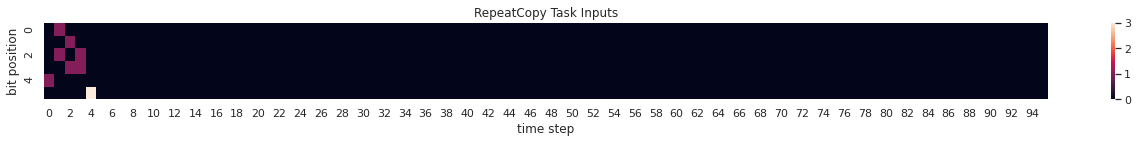

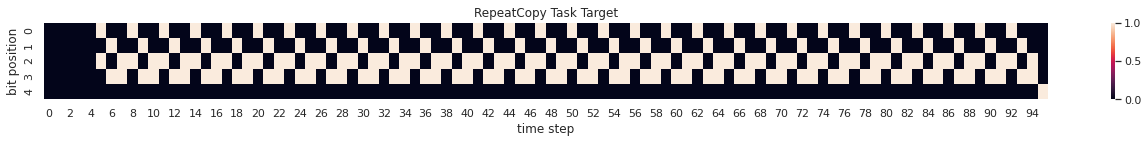

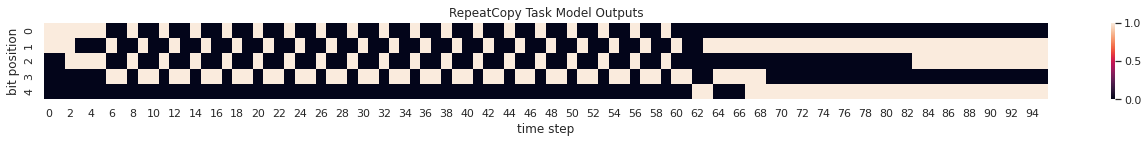

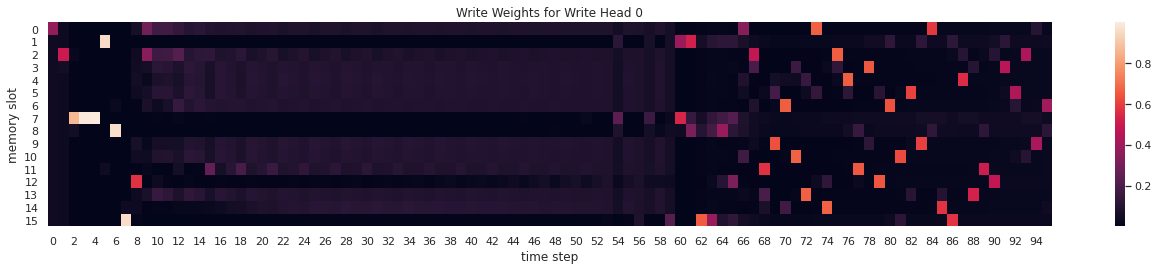

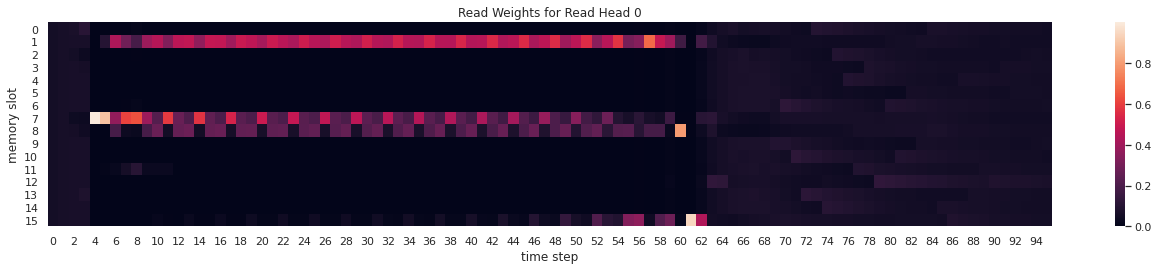

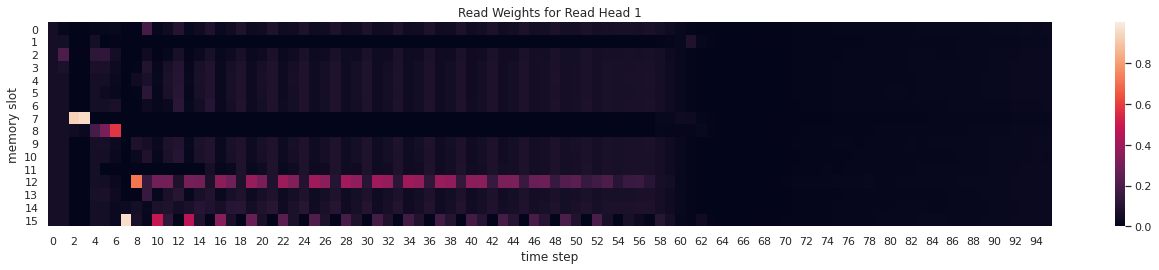

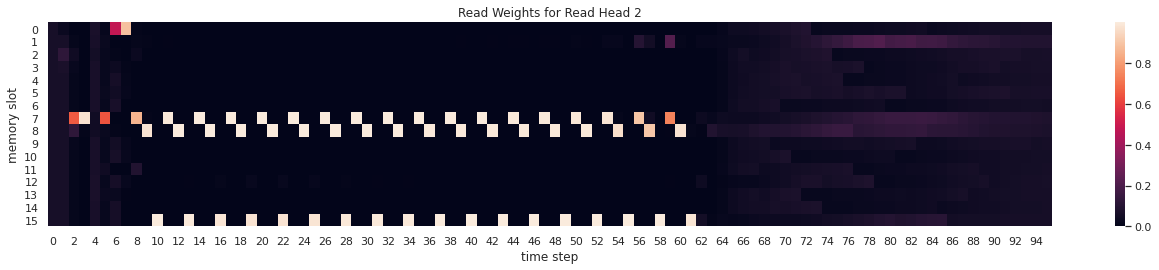

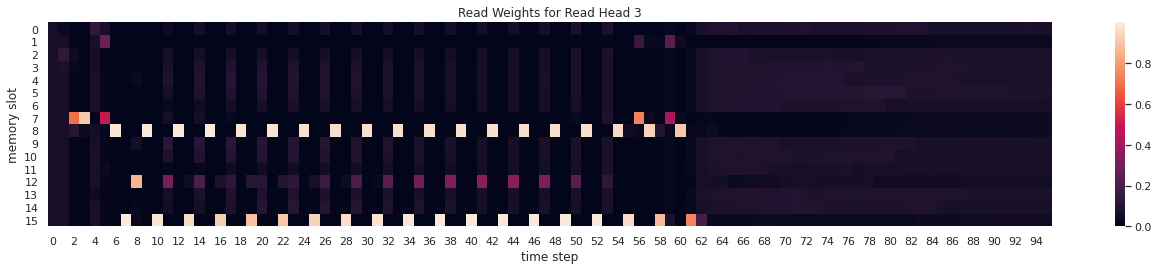

In [123]:
a = debug_model([[1,0,1,0], [0,1,0,1], [0,0,1,1]], 30)